## Analysis pipline for *Why pathway methods work?* project

### Preprocess gene sets

In [1]:
from subprocess import call
import sys
import pickle as pckl

sys.path.append('../code/')

In [2]:
#getting csv regulons from DoRothEA
call(['Rscript','../code/get_regulon_from_rdata.R'])

0

In [3]:
#getting csv gene sets from msigdb
call(['Rscript','../code/get_msigdb_genesets.R'])

0

In [2]:
import make_genesets

In [5]:
#prepocess dorothea regulons
for confidence in ['A','B','C','D','E','BEST']:
    make_genesets.make_gene_dict_dorothea(confidence)

In [6]:
#prepocess msigdb regulons
for setname in ['BIOCARTA','CGP','KEGG','REACTOME']:
    make_genesets.make_gene_dict_msigdb(setname)

In [7]:
#multi level gene sets for dorothea
make_genesets.make_multi_level_dorothea()

Checking the size of different gene sets.

In [3]:
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")

In [29]:
gene_set_lengths={}
for confidence in ['A','B','C','D','E','AB','ABC','ABCD','ABCDE','BEST']:
    fin=open('../results/genesets/dorothea/dicts/dorothea_%s_set_gene.pkl' % confidence,'br')
    genesets=pckl.load(fin)
    fin.close()
    l=[len(genesets[x]) for x in genesets.keys()]
    gene_set_lengths['DoRothEA_'+confidence]=l
for setname in ['CGP','KEGG','REACTOME','BIOCARTA']:
    fin=open('../results/genesets/msigdb//dicts/%s_set_gene.pkl' % setname,'br')
    genesets=pckl.load(fin)
    fin.close()
    l=[len(genesets[x]) for x in genesets.keys()]
    gene_set_lengths[setname]=l

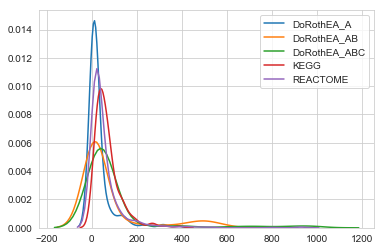

In [31]:
for confidence in ['DoRothEA_A','DoRothEA_AB','DoRothEA_ABC','KEGG','REACTOME']:
    sns.distplot(gene_set_lengths[confidence],hist=False,label=confidence)

Calculating similarities between gene sets: this runs for a long time, so was actually calculated on MTA virtual machines with **code/geneset_similarity.py**.

In [4]:
import os

In [9]:
#make csv files for regulons
fnames=os.listdir('../results/genesets/dorothea/dicts/')
fnames=[x for x in fnames if 'set_gene' in x]
for fname in fnames:
    make_genesets.make_csv_geneset('dorothea',fname[:-4])

In [12]:
fnames=os.listdir('../results/genesets/msigdb/dicts/')
fnames=[x for x in fnames if 'set_gene' in x]
for fname in fnames:
    make_genesets.make_csv_geneset('msigdb',fname[:-4])

In [14]:
#make rdata file from them for viper
call(['Rscript','../code/make_viper_regulon.R'])

0

### Preprocess benchamrking datasets
Now as we are having our gene sets (and gene set similarities) ready, we need the benchmarking datasets. For benchmarking we will use 2 datasets:
* perturbation gene expression profiles form PROGENy
* drug sensitivity data form GDSC dataset

In [5]:
import pandas as pd
import numpy as np

In [43]:
#PROGENY prepocess
zscores=pd.read_csv('../data/progeny/zscores_14PW_PROGENy.csv',sep=',',header=0,index_col=0)
indexes=pd.read_csv('../data/progeny/index_14PW_PROGENy.csv',sep=',',header=0,index_col=0)
indexes.index=indexes['id']
del indexes['id']

Text(0.5, 0, 'Number of missing genes')

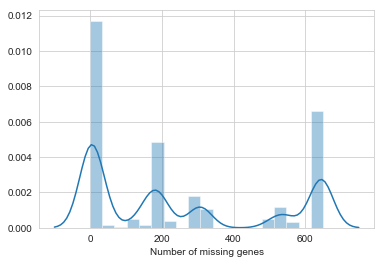

In [44]:
#removing NAs
sns.distplot(zscores.isna().sum(1))
plt.xlabel('Number of missing genes')

In [45]:
#we keep only genes with 0 missing values
fil=zscores.isna().sum(1)==0
zscores=zscores[fil]

In [46]:
set(indexes['pathway'])

{'Androgen',
 'EGFR',
 'Estrogen',
 'Hypoxia',
 'JAK-STAT',
 'MAPK',
 'NFkB',
 'PI3K',
 'TGFb',
 'TNFa',
 'Trail',
 'VEGF',
 'WNT',
 'WNT3',
 'p53'}

In [47]:
fil=indexes['pathway']=='WNT3'
indexes.loc[indexes.index[fil],'pathway']='WNT'

In [69]:
assert np.sum(indexes.index!=zscores.columns)==0

In [70]:
#multiply gene expressions with the sign of perturbation
zscores=zscores*indexes['sign']

In [80]:
zscores.to_csv('../results/benchmark/progeny/raw/progeny_data.csv',sep=',')
pd.DataFrame(indexes['pathway']).to_csv('../results/benchmark/progeny/raw/progeny_meta.csv',sep=',')

In [157]:
#GDSC data
gex=pd.read_csv('../data/gdsc/sanger1018_brainarray_ensemblgene_rma.txt',sep='\t',header=0,index_col=0)
cell_anno=pd.read_excel('../data/gdsc/Cell_Lines_Details.xlsx',skipfooter=1)
cell_anno['COSMIC identifier']=cell_anno['COSMIC identifier'].astype(str)

In [158]:
from statsmodels.nonparametric.smoothers_lowess import lowess

In [159]:
#normalise gex and translate gene ids
std_pred=lowess(np.std(gex,1),np.mean(gex,1),return_sorted=False)
gex=((gex.T-np.mean(gex,1))/std_pred).T

In [160]:
gene_anno=pd.read_csv('../data/gdsc/ensembl_hgnc.csv',sep=',',header=0,index_col=[0])
# remove not 1on1 translations and NaNs
gene_anno=gene_anno.drop_duplicates('ensembl_gene_id')
gene_anno=gene_anno.drop_duplicates('hgnc_symbol')
fil=np.sum(pd.isnull(gene_anno),1)==0
gene_anno=gene_anno[fil]
# translate gdsc gene ids gene symbol
gene_anno.index=gene_anno['ensembl_gene_id']
gene_anno=gene_anno['hgnc_symbol']
genes=list(set(gene_anno.index)&set(gex.index))
gex=gex.loc[genes]
gene_anno=gene_anno[genes]
gex.index=gene_anno.values

In [161]:
fil=(~pd.isnull(cell_anno['Cancer Type\n(matching TCGA label)'])) \
    & (cell_anno['Cancer Type\n(matching TCGA label)']!='UNABLE TO CLASSIFY') \
    & ~(pd.isnull(cell_anno['Microsatellite \ninstability Status (MSI)']))
cell_anno=cell_anno[fil]
cell_anno.index=cell_anno['COSMIC identifier']

In [162]:
cosmics=list(set(cell_anno.index)&set(gex.columns))
gex=gex[cosmics]
cell_anno=cell_anno.loc[cosmics]
cell_anno=cell_anno[['COSMIC identifier','Cancer Type\n(matching TCGA label)',
                     'Microsatellite \ninstability Status (MSI)']]
cell_anno.columns=['COSMIC','TCGA','MSI']

In [167]:
gex.round(3).to_csv('../results/benchmark/gdsc/raw/gdsc_gex.csv',sep=',')
cell_anno.to_csv('../results/benchmark/gdsc/raw/gdsc_cell.csv',sep=',')


### Calculating gene activity scores on benchmark data

In [8]:
call(['Rscript','../code/run_viper.R'])

0